### Initializiation

In [69]:
# these were discussed in lecture
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
%matplotlib notebook
import sys
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]


# Functions

### Cavity

In [78]:
def cavityPressure(p, b, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) -
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    pn = np.empty_like(p)
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

def cavityFlow(p, b, u, v, dx, dy, udiff, stepcount):
    while udiff > tol:
        un = u.copy()
        vn = v.copy()

        p = cavityPressure(p, b, u, v, dx, dy)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
        stepcount += 1

    return u, v, p, stepcount

### Forced

In [7]:
def pressurePeriodic(p, b, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) -
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    pn = np.empty_like(p)
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        
        # Periodic BC Pressure @ x = 2
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # Periodic BC Pressure @ x = 0
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # Wall boundary conditions, pressure
        p[-1, :] = p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :]  = p[1, :]   # dp/dy = 0 at y = 0
        
    return p


def forcedFlow(p, b, u, v, dx, dy):
    while udiff > tol:
        un = u.copy()
        vn = v.copy()


        p = pressurePeriodic(p, b, u, v, dx, dy)

        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx * 
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy * 
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * 
                        (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 * 
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                         F * dt)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx * 
                        (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy * 
                        (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                         dt / (2 * rho * dy) * 
                        (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                         nu * (dt / dx**2 *
                        (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                         dt / dy**2 * 
                        (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # Periodic BC u @ x = 2     
        u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                      (un[1:-1, -1] - un[1:-1, -2]) -
                       vn[1:-1, -1] * dt / dy * 
                      (un[1:-1, -1] - un[0:-2, -1]) -
                       dt / (2 * rho * dx) *
                      (p[1:-1, 0] - p[1:-1, -2]) + 
                       nu * (dt / dx**2 * 
                      (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                       dt / dy**2 * 
                      (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

        # Periodic BC u @ x = 0
        u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                     (un[1:-1, 0] - un[1:-1, -1]) -
                      vn[1:-1, 0] * dt / dy * 
                     (un[1:-1, 0] - un[0:-2, 0]) - 
                      dt / (2 * rho * dx) * 
                     (p[1:-1, 1] - p[1:-1, -1]) + 
                      nu * (dt / dx**2 * 
                     (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                      dt / dy**2 *
                     (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

        # Periodic BC v @ x = 2
        v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                      (vn[1:-1, -1] - vn[1:-1, -2]) - 
                       vn[1:-1, -1] * dt / dy *
                      (vn[1:-1, -1] - vn[0:-2, -1]) -
                       dt / (2 * rho * dy) * 
                      (p[2:, -1] - p[0:-2, -1]) +
                       nu * (dt / dx**2 *
                      (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                       dt / dy**2 *
                      (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

        # Periodic BC v @ x = 0
        v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                     (vn[1:-1, 0] - vn[1:-1, -1]) -
                      vn[1:-1, 0] * dt / dy *
                     (vn[1:-1, 0] - vn[0:-2, 0]) -
                      dt / (2 * rho * dy) * 
                     (p[2:, 0] - p[0:-2, 0]) +
                      nu * (dt / dx**2 * 
                     (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                      dt / dy**2 * 
                     (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))


        # Wall BC: u,v = 0 @ y = 0,2
        u[0, :] = 0
        u[-1, :] = 0
        v[0, :] = 0
        v[-1, :]=0

        udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
        stepcount += 1

    return u, v, p, stepcount


# Forced Flow Through a Pipe 

### Parameters

In [87]:
nx = 201
ny = 101

xspan = 20.
yspan = 10.
nit = 50
c = 1
tol = 0.001
qScale = 3
udiff = 1
stepcount = 0
    
dx = xspan / (nx - 1)
dy = yspan / (ny - 1)
x = np.linspace(0, xspan, nx)
y = np.linspace(0, yspan, ny)
X, Y = np.meshgrid(x, y)

qScale = 8

rho = 1
nu = .1
dt = .001
F = 1.

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))


### Plot

In  976  iterations, a tolerance of  0.001  was met.


<IPython.core.display.Javascript object>


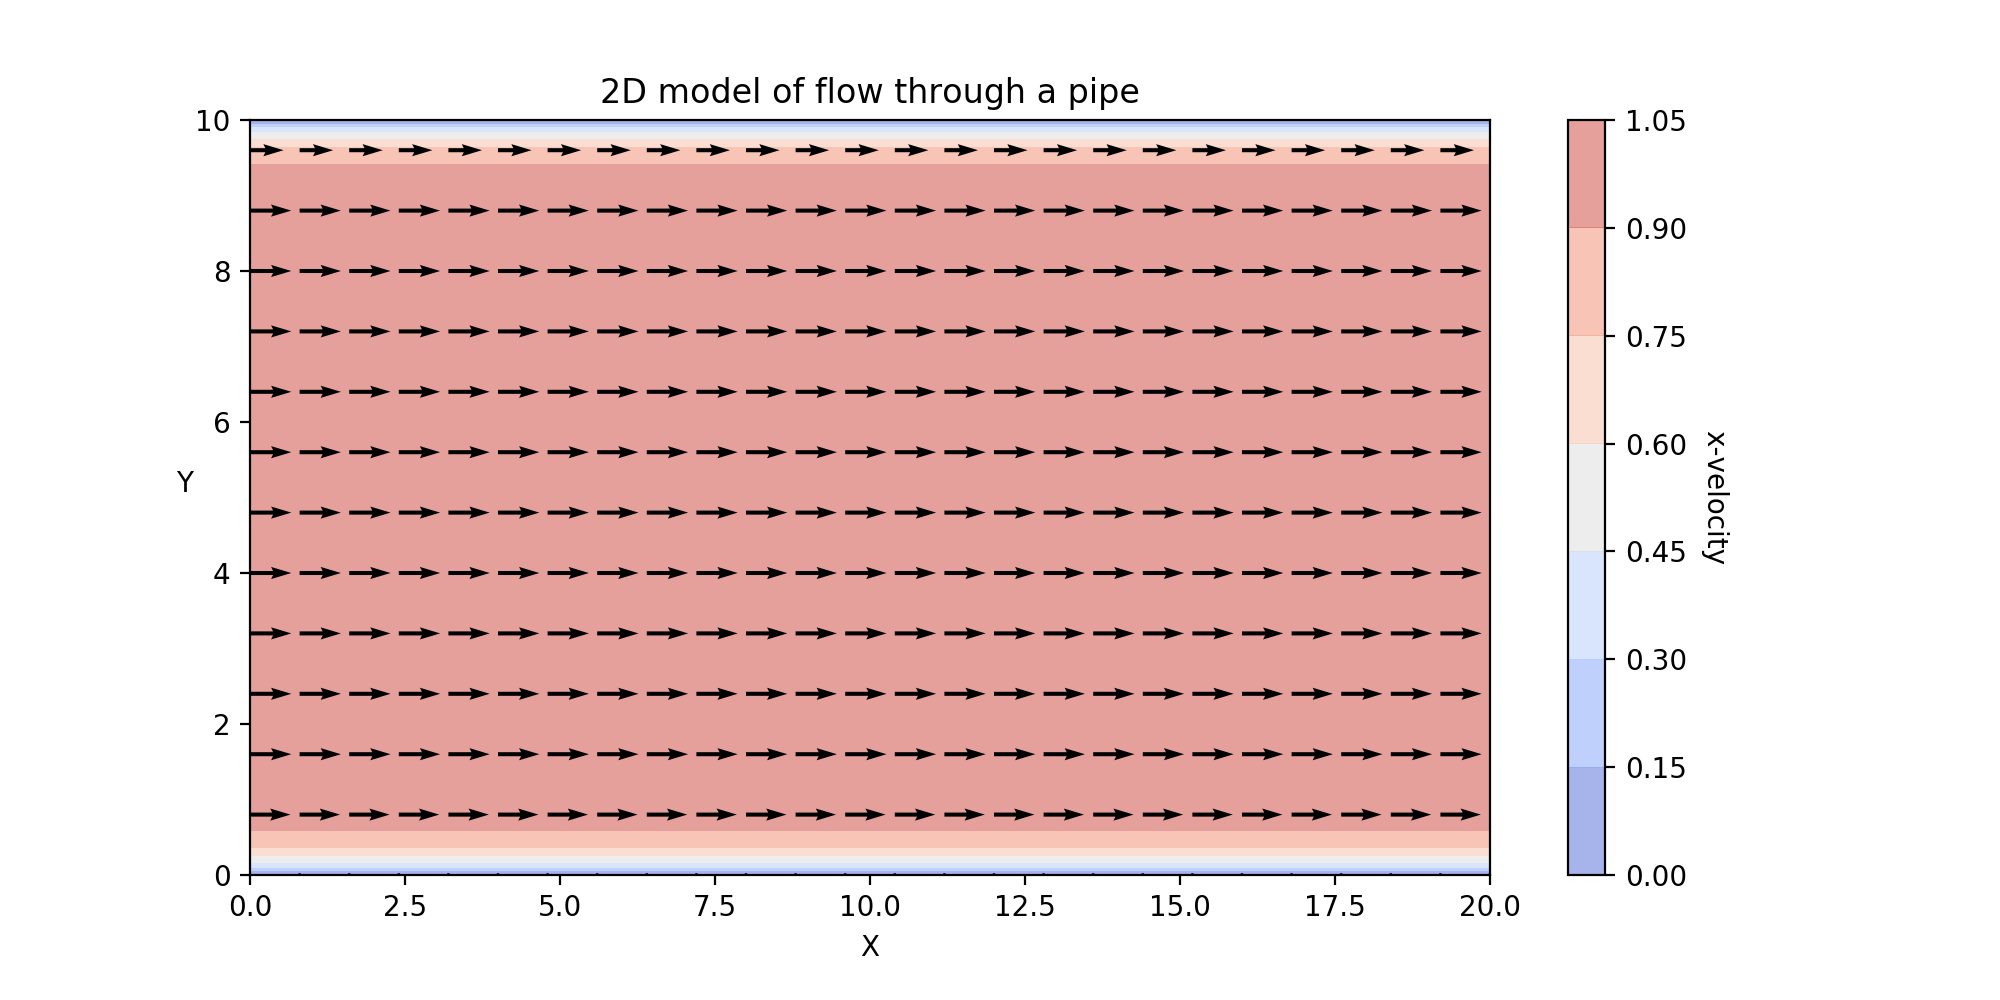

In [88]:
%matplotlib notebook
%matplotlib notebook
u, v, p, count = forcedFlow(p, b, u, v, dx, dy)
print('In ', count, ' iterations, a tolerance of ', tol, ' was met.')
figure = plt.figure(figsize=(10, 5), dpi=100)
plt.contourf(X, Y, u, cmap = cm.coolwarm, alpha = 0.5)
cbar = plt.colorbar()
cbar.set_label('x-velocity', rotation=270, labelpad = 15)
plt.quiver(X[::qScale, ::qScale], Y[::qScale, ::qScale], u[::qScale, ::qScale], v[::qScale, ::qScale])
#plt.grid()
plt.xlabel('X')
plt.ylabel('Y', rotation = 0)
plt.title('2D model of flow through a pipe')
plt.show()

# Cavity Flow

### Parameters

In [79]:
nx = 41
ny = 41

xspan = 2.
yspan = 2.
nit = 50
c = 1
udiff = 1
stepcount = 0

dx = xspan / (nx - 1)
dy = yspan / (ny - 1)
x = np.linspace(0, xspan, nx)
y = np.linspace(0, yspan, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001
qScale = 2



### Plot

In  59  iterations, a tolerance of  0.001  was met.


<IPython.core.display.Javascript object>


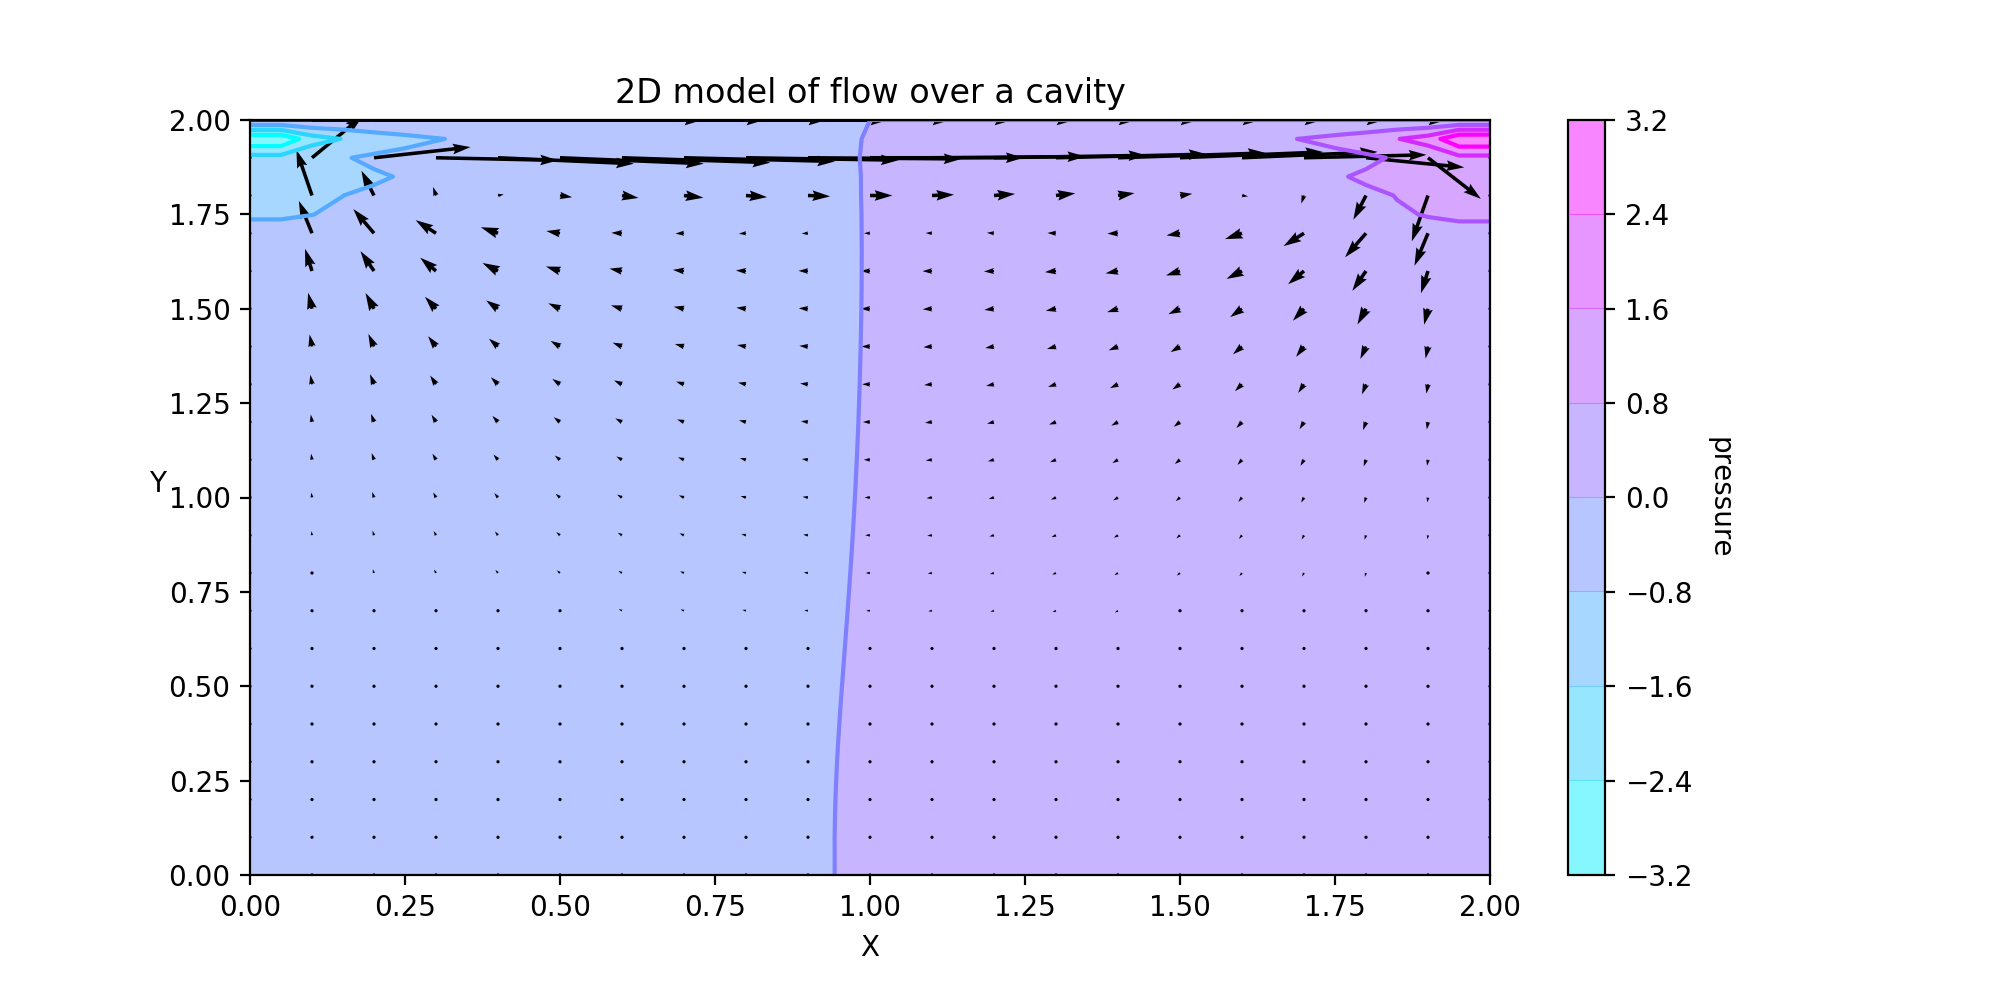

In [85]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p, count = cavityFlow(p, b, u, v, dx, dy, udiff, stepcount)

print('In ', count, ' iterations, a tolerance of ', tol, ' was met.')
figure = plt.figure(figsize=(10, 5), dpi=100)
plt.contourf(X, Y, p, cmap = cm.cool, alpha = 0.5)
cbar = plt.colorbar()
cbar.set_label('pressure', rotation=270, labelpad = 15)
plt.contour(X, Y, p, cmap = cm.cool)
plt.quiver(X[::qScale, ::qScale], Y[::qScale, ::qScale], u[::qScale, ::qScale], v[::qScale, ::qScale])
#plt.grid()
plt.xlabel('X')
plt.ylabel('Y', rotation = 0)
plt.title('2D model of flow over a cavity')
plt.show()